In [1]:
# https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

Time series provide the opportunity to forecast future values. Based on previous values, time series can be used to forecast trends in economics, weather, and capacity planning

One of the methods available in Python to model and predict future points of a time series is known as SARIMAX, which stands for Seasonal AutoRegressive Integrated Moving Averages with eXogenous regressors. Here, we will primarily focus on the ARIMA component, which is used to fit time-series data to better understand and forecast future points in the time series.

## ARIMA stands for AutoregRessive Integrated Moving Average. ARIMA is a model that can be fitted to time series data in order to better understand or predict future points in the series.

### There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. Because of that, ARIMA models are denoted with the notation ARIMA(p, d, q). Together these three parameters account for seasonality, trend, and noise in datasets:

## p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
## d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
## q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
### When dealing with seasonal effects, we make use of the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).

When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

## Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In this case, our model diagnostics suggests that the model residuals are normally distributed based on the following:

## In the top right plot, we see that the red KDE line follows closely with the N(0,1) line (where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). This is a good indication that the residuals are normally distributed.
## The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.
## The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.
Those observations lead us to conclude that our model produces a satisfactory fit that could help us understand our time series data and forecast future values.

Although we have a satisfactory fit, some parameters of our seasonal ARIMA model could be changed to improve our model fit. For example, our grid search only considered a restricted set of parameter combinations, so we may find better models if we widened the grid search.

In [3]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [9]:
#data = sm.datasets.co2.load_pandas()
#y = data.data

In [15]:
y = pd.DataFrame.from_records(sm.datasets.co2.load().data)
y['date'] = y.date.apply(lambda x: x.decode('utf-8'))
y['date'] = pd.to_datetime(y.date, format='%Y%m%d')
y.set_index('date').head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


Let's preprocess our data a little bit before moving forward. Weekly data can be tricky to work with since it’s a briefer amount of time, so let's use monthly averages instead. We’ll make the conversion with the resample function. For simplicity, we can also use the fillna() function to ensure that we have no missing values in our time series.

In [18]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2284 entries, 0 to 2283
Data columns (total 2 columns):
date    2284 non-null datetime64[ns]
co2     2225 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 35.8 KB


In [24]:
y.index = pd.to_datetime(y.date)

In [29]:
y=y.resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y.head())

                   co2
date                  
1958-03-01  316.100000
1958-04-01  317.200000
1958-05-01  317.433333
1958-06-01  315.625000
1958-07-01  315.625000


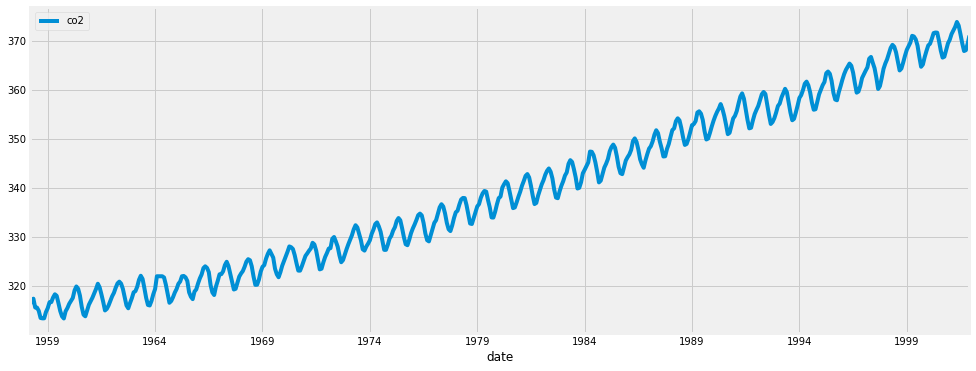

In [30]:
y.plot(figsize=(15, 6))
plt.show()

In [31]:
# build SARIMAX model: select the parameters (p,q,d,s)

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [32]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7612.583429881011
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:6787.343624036737
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1854.828234141261
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1596.7111727641156
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1058.9388921320026
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1056.2878324743037
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1361.6578978072075
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1044.7647913337166
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:6881.048754074922
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:6072.662327716935
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1379.194106691656
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1241.4174716765563
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1108.863847677881
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:817.1761857973631
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1119.5957893612945
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:807.0912988550028
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1675.8086923024293
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1240.2211199194094
A

In [33]:
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:277.7802199727904 is lowest


In [34]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3182      0.092      3.442      0.001       0.137       0.499
ma.L1         -0.6254      0.077     -8.164      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.813      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.633      0.000       0.089       0.106


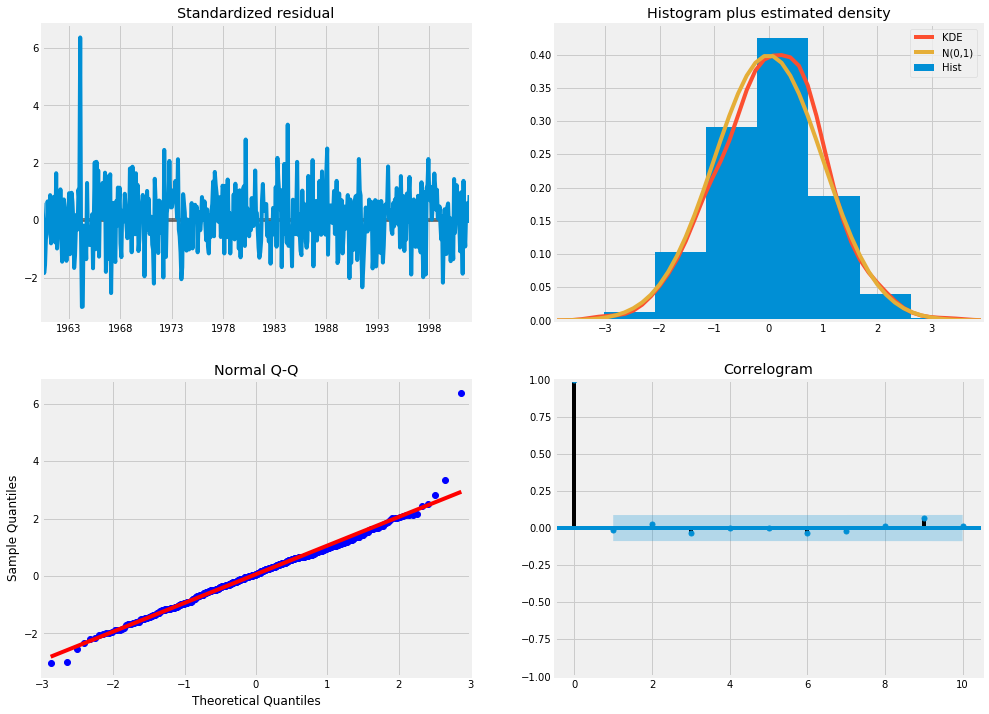

In [35]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()